импорт всех нужных библиотек

In [1]:
from sklearn.model_selection import train_test_split
import torch
import sys
import os
from model import KANTrainer,KANPERCE
from kan import *

import matplotlib.pyplot as plt
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Загрузка и подготовка данных для анализа и обучения модели.<br>
разбиение на train,test


In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
pd_params = (10,9,50,1)
window_size,num_features,downsample_step,target_window_size = pd_params 

# Подготовка данных
X, y, df = PD.vec_to_vec(
    window_size,
    num_features,
    downsample_step,
    target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = PD.PDtrain_test_split(
    X, y, test_size=0.33, random_state=42
)
dataset = {'train_input':X_train, 'test_input':X_test, 'train_label':y_train, 'test_label':y_test}
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([14182, 89]),
 torch.Size([6986, 89]),
 torch.Size([14182, 1]),
 torch.Size([6986, 1]))

In [3]:
import torch
print(torch.__version__)

2.3.0+cu118


In [4]:

#инициализация модели
# in_dim = X_train.shape[1]
# out_dim = target_window_size
# hid = 16
# dropout = 0.1
# num = 5
# k = 3
# noise_scale = 0.5
# scale_base_mu = 0.0
# scale_base_sigma = 1.0
# scale_sp = 1.0
# base_fun  = torch.nn.SiLU()
# grid_eps = 0.02
# grid_range  = [-5,5]
width = [84,200,21]
grid=  15
k = 10
noise_scale = 0.2
grid_range = [-100,100]
model = KAN(width=width, grid=grid, k=k, noise_scale=noise_scale, grid_range = grid_range,seed=2,device = device)
# model = KANPERCE(
# in_dim = in_dim,
# out_dim = out_dim,
# hid = hid,
# dropout = dropout,
# num = num,
# k = k, 
# noise_scale = noise_scale,
# scale_base_mu = scale_base_mu,
# scale_base_sigma = scale_base_sigma,
# scale_sp = scale_sp,
# base_fun  = base_fun,
# grid_eps = grid_eps,
# grid_range  = grid_range,
# device = device)
lr = 1e-5
trainer = KANTrainer(
    model=model,
    learning_rate=lr,
    fit2 = False,
    
    inf_per_epoch = 10,
    device= device
)

checkpoint directory created: ./model
saving model version 0.0


In [5]:
batch_size = 64
history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=batch_size,
    epochs=3000,
    loss_tube=5
)

| train_loss: 1.43e+01 | test_loss: 1.37e+01 | reg: 9.35e+02 | : 100%|█| 3000/3000 [28:08<00:00,  1.


saving model version 0.1


In [6]:
losses=  {
            'train_main_loss': [arr.item() for arr in history['train_loss']],
            'train_mape': torch.zeros((len(history['mape']))).tolist(),
            'train_tube': history['tube'],
            'test_mape': history['mape'],
            'test_tube': history['tube']
            }

In [7]:
from model_history import ModelHistory
MH = ModelHistory(losses)
MH.save_history_json(filename = BASE_DIR+'\loss_history/all_loss.json',model_name = 'KAN')
key = MH.add_result(
        filename = BASE_DIR+'\\resualt/main.json',
        model_name = 'KAN',
        result = 'best',
        message = 'first',
        params = {'input_size' : X_train.shape[1],
                  'width':width,
                  'grid':grid,
                  'k':k,
                  'noise_scale':noise_scale, 
                  'seed':2,
                  'lr':1e-5,
                  'batch_size':64,
                  'lr':lr,
                  'grid_range': grid_range}
        )
key

'e7ea9473-a14f-4971-a5d1-6601ac3f53d2'

In [8]:
LV = LossVisualizer(losses)

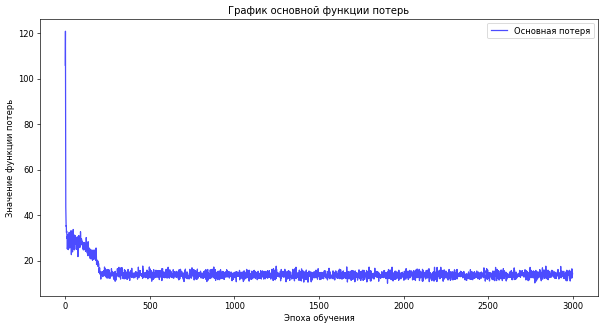

In [9]:
LV.show_training_loss()

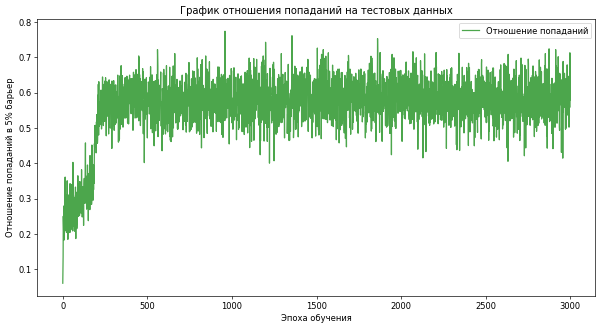

In [10]:
LV.show_test_tube()

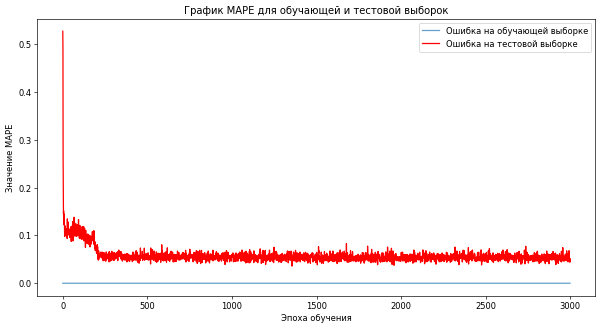

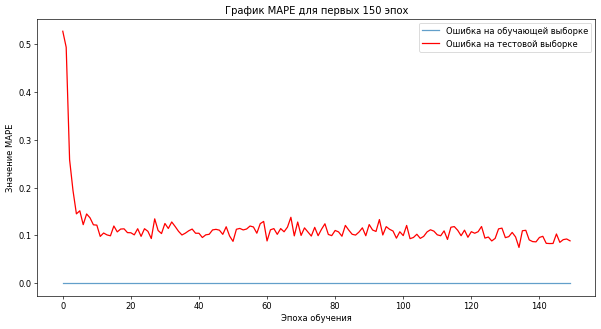

In [11]:
LV.show_mape()

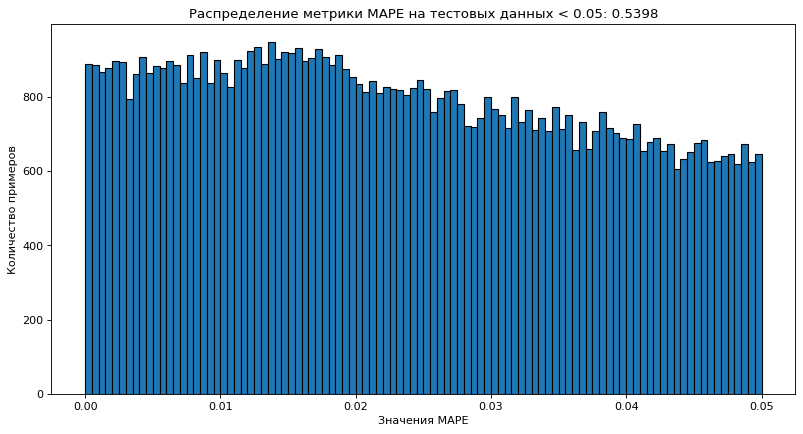

Процент значений MAPE < 0.05: 0.5398


In [12]:
LV.histogram_mape(model,X_test,y_test,limit_percel = 5)

Количество записей: 5334


ValueError: x and y must be the same size

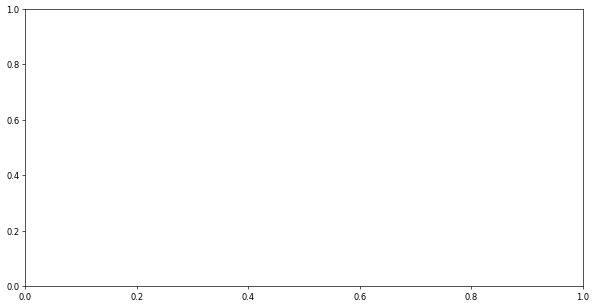

In [25]:
LV.show_predictions(model,df,pd_params,keras=False,device=device)